In [36]:
import pandas as pd
import datetime
from my_pysyncon import Dataprep, Synth, AugSynth

In [37]:
df_mo = pd.read_csv('../../../Dataset_Generation/Jared/Data/total_state_data.csv')
df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['energy_prod'] / df_mo['monthly_population']
df_mo['eflow_per_capita'] = df_mo['energy_flow'] / df_mo['monthly_population']

df_yr = pd.read_csv('../../../Dataset_Generation/Jared/Data/yearly_total_data.csv')
df_yr['co2_per_capita'] = df_yr['total_co2'] / df_yr['yearly_population']
df_yr['gdp_per_capita'] = df_yr['yearly_gdp_rel_2017'] / df_yr['yearly_population']
df_yr['eprod_per_capita'] = df_yr['energy_prod'] / df_yr['yearly_population']
df_yr['eflow_per_capita'] = df_yr['energy_flow'] / df_yr['yearly_population']

In [50]:
df_yr.head()

,Unnamed: 0,state,year,yearly_population,prcp,snow,tavg,yearly_gdp_rel_2017,energy_prod,energy_use,energy_flow,total_co2,co2_per_capita,gdp_per_capita,eprod_per_capita,eflow_per_capita
0,0,AL,1990,4050055.0,6.022500,0.000000,63.158333,NaN,1269484.0,1599432.0,-329948.0,5.665440e+07,13.988552,NaN,0.313449,-0.081468
1,1,AL,1991,4099156.0,5.857500,0.000000,62.416667,NaN,1300485.0,1618216.0,-317731.0,6.105681e+07,14.894970,NaN,0.317257,-0.077511
2,2,AL,1992,4154014.0,4.635833,0.016667,60.041667,NaN,1413636.0,1691870.0,-278234.0,6.418824e+07,15.452099,NaN,0.340306,-0.066980
3,3,AL,1993,4214202.0,4.299167,0.608333,60.383333,NaN,1421826.0,1744734.0,-322908.0,7.055293e+07,16.741706,NaN,0.337389,-0.076624
4,4,AL,1994,4260229.0,5.509167,0.008333,60.958333,NaN,1558410.0,1822330.0,-263920.0,6.605834e+07,15.505820,NaN,0.365804,-0.061950


In [39]:
time_range = df_mo.date

# these are the time values where CO2 per capita is fit
preintervention_time_range = df_mo.date[(df_mo.date >= '1990-06-01')&(df_mo.date<'2009-01-01')]

# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1997-01-01') & (df_mo.date<'2009-01-01')]
preintervention_weather_range = df_mo.date[(df_mo.date >= '1990-01-01') & (df_mo.date<'2009-01-01')]
preintervention_gdp_range = df_mo.date[(df_mo.date >= '1997-12-01') & (df_mo.date<'2009-01-01')]
preintervention_per_capita_range = df_mo.date[(df_mo.date >= '1990-06-01') & (df_mo.date<'2009-01-01')]

# these are the dates used for our monthly graph
years= pd.date_range(start='1990-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [40]:
# we leave off RGGI states, states with no CO2 data (AK, HI), as well as states with some type of cap-and-trade program (CA)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']

non_rggi_controls_identifier= [
    "AL", 
    #"AK", 
    "AZ", "AR", 
    #"CA", 
    "CO", 
    #"CT", 
    #"DE", 
    "FL", 
    "GA",
    #"HI", 
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", 
    #"ME", 
    #"MD",
    #"MA", 
    "MI", "MN", "MS", "MO", "MT", "NE", "NV", 
    #"NH", 
    #"NJ",
    "NM", "NC", "ND", "OH", "OK", "OR", "PA", 
    #"RI", 
    "SC", "SD", "TN", "TX", "UT", 
    #"VT", 
    #"VA", 
    "WA", "WV", "WI", "WY"
    ]

In [ ]:
# we create a synthetic control Delaware as applied to monthly data

dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_per_capita_range, "mean"),
        ('eflow_per_capita', preintervention_per_capita_range, "mean"),
        ("snow", preintervention_weather_range, "mean"),
        ('prcp', preintervention_weather_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: AL, AZ, AR, CO, FL, GA, ID, IL, IN, IA, KS, KY, LA, MI, MN, MS, MO, MT, NE, NV, NM, NC, ND, OH, OK, OR, PA, SC, SD, TN, TX, UT, WA, WV, WI, WY
Time range in data: 1990-01-01 - 2024-12-01
Time range for loss minimization: 5        1990-06-01
6        1990-07-01
7        1990-08-01
8        1990-09-01
9        1990-10-01
            ...    
11167    2008-08-01
11168    2008-09-01
11169    2008-10-01
11170    2008-11-01
11171    2008-12-01
Name: date, Length: 10927, dtype: object
Time range for predictors: 4116     1997-01-01
4117     1997-02-01
4118     1997-03-01
4119     1997-04-01
4120     1997-05-01
            ...    
11167    2008-08-01
11168    2008-09-01
11169    2008-10-01
11170    2008-11-01
11171    2008-12-01
Name: date, Length: 7056, dtype: object
Predictors: 
Special predictors:
    `eprod_per_capita` over `5        1990-06-01
6        1990-07-01
7        1990-08-01
8        1990-09-01
9        1990

In [ ]:
# we create a synthetic control Delaware as applied to yearly data

dataprep_yr = Dataprep(
    foo=df_yr,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=range(1997,2010),
        special_predictors=[
        ('eprod_per_capita', range(1990,2010), "mean"),
        ('eflow_per_capita', range(1990,2010), "mean"),
        ("snow", range(1990,2010), "mean"),
        ('prcp', range(1990,2010), "mean"),
        ('gdp_per_capita', range(1997,2010), "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=range(1990,2010)
)

print(dataprep_yr)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: AL, AZ, AR, CO, FL, GA, ID, IL, IN, IA, KS, KY, LA, MI, MN, MS, MO, MT, NE, NV, NM, NC, ND, OH, OK, OR, PA, SC, SD, TN, TX, UT, WA, WV, WI, WY
Time range in data: 1990 - 2024
Time range for loss minimization: range(1990, 2010)
Time range for predictors: range(1997, 2010)
Predictors: snow, prcp, tavg, gdp_per_capita, eprod_per_capita, eflow_per_capita




We supply the `Dataprep` object to a `Synth` object. The optimization scheme we could use is [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) and the starting point we could use for the optimisation is `ols` i.e. the initial weights are obtained by fitting an ordinary-least-squares estimate. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point.*

In [43]:
# monthly version

synth_mo = Synth()
synth_mo.fit(dataprep=dataprep_mo)
print(synth_mo.weights(threshold=.01))

IL    1.0
Name: weights, dtype: float64


This is saying that Delaware is $49.3\%$ Illinois, $49.1\%$ Nevada, and $1.5\%$ Minnesota (all other percentages are negligible).


In [44]:
# yearly version

synth_yr= Synth()
synth_yr.fit(dataprep=dataprep_yr,optim_initial='ols')
print(synth_yr.weights(threshold=.01))

IL    0.189
MN    0.187
NV    0.623
Name: weights, dtype: float64


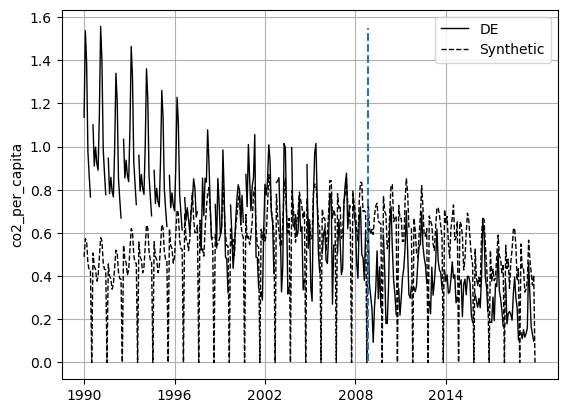

In [45]:
# Monthly synthetic control plot

synth_mo.path_plot(time_period=years, treatment_time='2009-01-01')

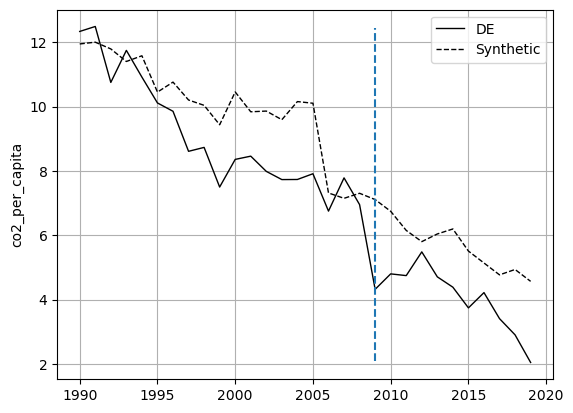

In [46]:
# Yearly synthetic control plot

synth_yr.path_plot_orig(time_period=range(1990,2020), treatment_time=2009)

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [47]:
synth_mo.summary()

,V,treated,synthetic,sample mean
special.1.eprod_per_capita,0.2,0.002,0.162,0.751
special.2.eflow_per_capita,0.2,-0.358,-0.157,0.361
special.3.snow,0.2,0.800,0.906,1.703
special.4.prcp,0.2,3.840,3.076,2.755
special.5.gdp_per_capita,0.2,0.006,0.005,0.004


In [48]:
synth_yr.summary()

,V,treated,synthetic,sample mean
snow,0.001,0.921,1.622,1.683
prcp,0.000,4.047,1.257,2.724
tavg,0.000,57.407,60.467,56.125
gdp_per_capita,0.001,0.078,0.057,0.046
eprod_per_capita,0.109,0.002,0.044,0.801
eflow_per_capita,0.889,-0.348,-0.257,0.410


## RGGI State Synthetic Control Comparisons

First, we compare the RGGI synthetic controls at the monthly level.

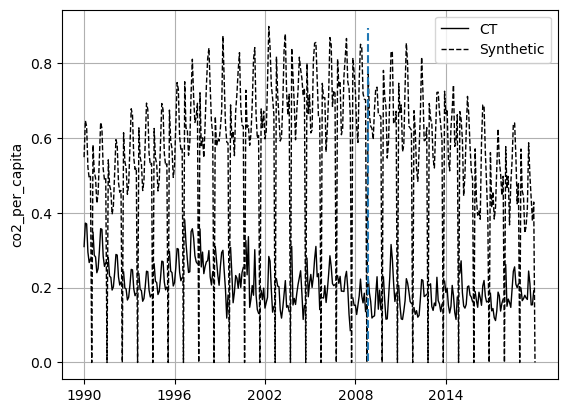

State: CT 

IL    0.805
MN    0.189
Name: weights, dtype: float64 

                            V  treated  synthetic  sample mean
eprod_per_capita          0.2    0.049      0.220        0.798
eflow_per_capita          0.2   -0.191     -0.108        0.404
special.1.snow            0.2    2.519      2.187        1.703
special.2.prcp            0.2    3.634      2.976        2.755
special.3.gdp_per_capita  0.2    0.006      0.005        0.004


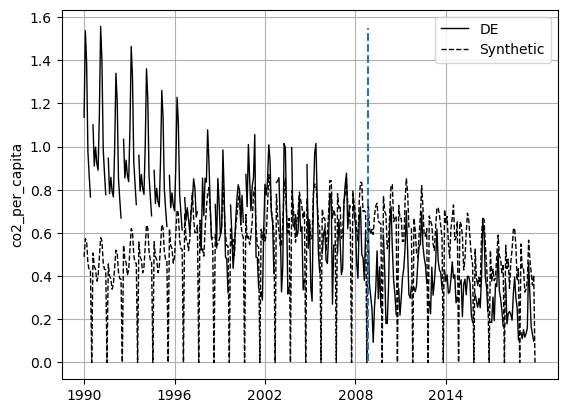

State: DE 

IL    1.0
Name: weights, dtype: float64 

                            V  treated  synthetic  sample mean
eprod_per_capita          0.2    0.002      0.151        0.798
eflow_per_capita          0.2   -0.354     -0.168        0.404
special.1.snow            0.2    0.800      0.906        1.703
special.2.prcp            0.2    3.840      3.076        2.755
special.3.gdp_per_capita  0.2    0.006      0.005        0.004


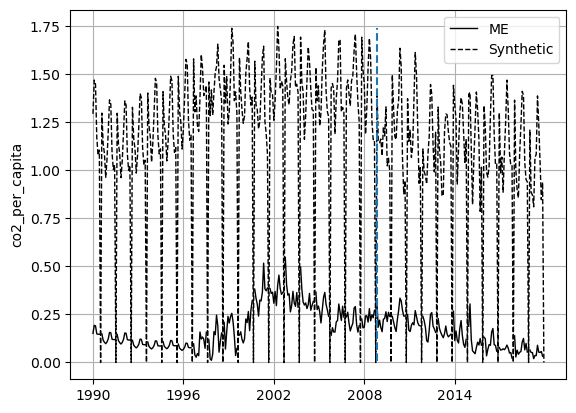

State: ME 

MN    0.522
MS    0.261
WV    0.217
Name: weights, dtype: float64 

                            V  treated  synthetic  sample mean
eprod_per_capita          0.2    0.100      0.566        0.798
eflow_per_capita          0.2   -0.224      0.187        0.404
special.1.snow            0.2    5.544      4.482        1.703
special.2.prcp            0.2    3.958      3.357        2.755
special.3.gdp_per_capita  0.2    0.004      0.004        0.004


KeyboardInterrupt: 

In [49]:
# loop through all RGGI states to see their monthly graphs

for state in rggi_states:
    dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['eprod_per_capita', 'eflow_per_capita'], # 'tavg'
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ("snow", preintervention_weather_range, "mean"),
        ('prcp', preintervention_weather_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean")
    ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state,
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

    # monthly version

    synth_mo = Synth()
    synth_mo.fit(dataprep=dataprep_mo)

    synth_mo.path_plot(time_period=years, treatment_time='2009-01-01')

    print('State:', state,'\n')
    print(synth_mo.weights(threshold=.01),'\n')
    print(synth_mo.summary())
    